In [4]:
import jaxopt
import matplotlib.pyplot as plt
import numpy as np
import optax

from experiments import find_nonzero_pauli, find_fixed_angles
from pauli import all_local_two_body_pauli, all_two_body_pauli
from traps import LocalVQA

import jax

jax.config.update("jax_enable_x64", True)

In [19]:
from typing import List, Sequence, Callable, Union
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
import pennylane as qml
import jax.numpy as jnp


class LocalVQA:
    def __init__(self, num_qubits: int, num_layers: int):

        assert num_qubits % 2 == 0
        self.num_qubits = num_qubits
        self.num_layers = num_layers

        # Parameters for qiskit circuit
        self._x0 = [Parameter(f'x{n}') for n in range(self.num_qubits)]
        self._z0 = [Parameter(f'z{n}') for n in range(self.num_qubits)]
        self._x = [[Parameter(f'x{n}{l}') for n in range(self.num_qubits)] for l in range(self.num_layers)]
        self._z = [[Parameter(f'z{n}{l}') for n in range(self.num_qubits)] for l in range(self.num_layers)]

    @property
    def num_initial_parameters(self) -> int:
        return 2 * self.num_qubits

    @property
    def num_entangling_parameters(self) -> int:
        return 2 * self.num_qubits * self.num_layers

    @property
    def num_parameters(self) -> int:
        return self.num_initial_parameters + self.num_entangling_parameters

    @property
    def _flat_params(self) -> List[Parameter]:
        return self._x0 + self._z0 + [xnl for xn in self._x for xnl in xn] + [znl for zn in self._z for znl in zn]

    def _params_dict(self, params: np.ndarray) -> dict:
        return dict(zip(self._flat_params, params))

    @property
    def initial_circuit(self):
        qc = QuantumCircuit(self.num_qubits)
        for n in range(self.num_qubits):
            qc.rx(self._x0[n], n)
            qc.rz(self._z0[n], n)

        return qc

    def entangling_layer(self, x, z, start=0):
        qc = QuantumCircuit(self.num_qubits)
        for n in range(start, self.num_qubits + start, 2):
            i = n % self.num_qubits
            j = (n + 1) % self.num_qubits
            qc.cz(i, j)

        for n in range(self.num_qubits):
            qc.rx(x[n], n)
            qc.rz(z[n], n)

        return qc

    @property
    def all_entangling_layers(self):
        qc = QuantumCircuit(self.num_qubits)

        s = 0
        for xi, zi in zip(self._x, self._z):
            qc.compose(self.entangling_layer(xi, zi, start=s), inplace=True)
            s = 1 - s

        return qc

    def split_params(self, params: np.ndarray) -> Sequence[np.ndarray]:
        n = self.num_qubits
        x0 = params[:n]
        z0 = params[n: 2 * n]

        num_x = len(params[2 * n:]) // 2
        x = params[2 * n: 2 * n + num_x]
        z = params[2 * n + num_x:]

        return x0, z0, x.reshape(self.num_layers, self.num_qubits), z.reshape(self.num_layers, self.num_qubits)

    @property
    def qiskit_circuit(self) -> QuantumCircuit:
        qc = QuantumCircuit(self.num_qubits)
        qc.compose(self.initial_circuit, inplace=True)
        qc.compose(self.all_entangling_layers, inplace=True)
        return qc

    @property
    def penny_circuit_from_qiskit(self):
        return qml.from_qiskit(self.qiskit_circuit)

    def penny_circuit(self, params):

        for n in range(self.num_qubits):
            qml.RX(0, wires=n)


    def expval(self, pauli_strings: Sequence[str]) -> Callable[[np.ndarray], np.ndarray]:

        dev = qml.device('lightning.qubit', wires=self.num_qubits)
        @qml.qnode(dev)
        def circ(x: np.ndarray):
            self.penny_circuit(x)
            return qml.state()

        observables = [qml.pauli.string_to_pauli_word(pauli) for pauli in pauli_strings]
        @qml.qjit
        def expectation(x: np.ndarray) -> np.ndarray:
            state = circ(x) # .reshape([2] * self.num_qubits)
            return state

        return expectation
    
vqa = LocalVQA(2, 3)
print(qml.draw(vqa.penny_circuit)(()))
ev = vqa.expval(['XX'])

# ev(x)


0: ──RX(0.00)─┤  
1: ──RX(0.00)─┤  


TypeError: Argument type <class 'numpy.ndarray'> is not a valid JAX type.

In [57]:
from typing import Sequence
from typing import Callable
import pennylane as qml
from catalyst import qjit
import jax.numpy as jnp

class myvqa:
    def __init__(self, num_qubits):
        self.num_qubits = num_qubits
    
    def penny_circuit(self, params):
        # x0, z0, x, z = self.split_params(params)
        x0 = jnp.zeros(self.num_qubits)
        z0 = jnp.zeros(self.num_qubits)
        for n in range(self.num_qubits):
            qml.RX(x0[n], wires=n)
            qml.RZ(z0[n], wires=n)
    
    def expval(self, pauli_strings):

        dev = qml.device('lightning.qubit', wires=self.num_qubits)
        @qml.qnode(dev)
        def circ(x):
            self.penny_circuit(x)
            return qml.state()

        observables = [qml.pauli.string_to_pauli_word(pauli) for pauli in pauli_strings]
        @qml.qjit
        def expectation(x):
            state = circ(x) # .reshape([2] * self.num_qubits)
            return state
            # return qml.devices.qubit.measure(qml.expval(observables[0]), state)
            # res = [qml.devices.qubit.measure(qml.expval(obs), state) for obs in observables]
            # return jnp.asarray(res)

        return expectation            

    def expval0(self, observables):
        
        dev = qml.device('lightning.qubit', wires=self.num_qubits)
        @qml.qnode(dev)
        def circ(x):
            self.penny_circuit(x)
            return qml.state()
        
        @qml.qjit
        def ev(x):
            print('compling')
            state = circ(x).reshape([2] * self.num_qubits)
            return jnp.asarray([qml.devices.qubit.measure(qml.expval(qml.pauli.string_to_pauli_word(obs)), state) for obs in observables])
        
        return ev
    
num_qubits = 2
vqa = myvqa(num_qubits)
ev = vqa.expval(('X', 'Y', 'Z'))

x = jnp.linspace(0, 1, num_qubits)
ev(x)

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

compling


AttributeError: 'myvqa' object has no attribute 'num_layers'

In [30]:
ev = get_ev(('X', 'Y', 'Z'))

In [33]:
ev(0.)

array([0., 0., 1.])

In [79]:
rng = np.random.default_rng(42)

num_qubits = 4
num_layers = 50
vqa = LocalVQA(num_qubits, num_layers)

observables = all_two_body_pauli(num_qubits)
coefficients = rng.uniform(low=-1, high=1, size=len(observables))

def loss(x):
    values = vqa.expval(observables, x)
    return (values * coefficients).sum()

In [89]:
learning_rate = 0.01
num_iterations = 5000
num_initial_points = 100
opt = optax.adam(learning_rate)

solver = jaxopt.OptaxSolver(loss, opt, maxiter=num_iterations, jit=True)

x0 = 2 * np.pi * rng.uniform(size=(num_initial_points, vqa.num_parameters))
values = jax.vmap(solver.run)(x0)

2024-03-20 17:29:47.352284: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 10m45.456206212s

********************************
[Compiling module jit_update] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-03-20 17:32:06.951781: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__while_loop_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-03-20 17:40:41.088856: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 10m34.137158575s

********************************
[Compiling module jit__while_loop_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [90]:
values

OptStep(params=Array([[2.15593290e+00, 1.65542331e-01, 5.91269535e+00, ...,
        2.53727571e+00, 6.17820900e+00, 2.98394206e+00],
       [3.67240276e+00, 2.34075569e+00, 4.18809138e+00, ...,
        1.87150909e+00, 2.22968318e+00, 2.54832402e+00],
       [1.69864175e+00, 4.79885333e+00, 5.04705621e+00, ...,
        9.73766814e-02, 4.38300650e+00, 8.67853806e-01],
       ...,
       [5.19087214e+00, 5.18885823e+00, 1.34276899e+00, ...,
        3.94982239e+00, 1.79250484e+00, 5.73350589e+00],
       [4.67193729e+00, 2.37051065e+00, 2.71539429e+00, ...,
        4.65701315e+00, 4.04821331e+00, 4.75252460e+00],
       [2.13977148e+00, 4.52503602e+00, 3.40588926e+00, ...,
        1.79412968e+00, 4.92013030e-03, 3.48758798e+00]], dtype=float64), state=OptaxState(iter_num=Array([180, 180, 189, 180, 186, 177, 182, 183, 184, 185, 179, 184, 182,
       178, 180, 181, 181, 182, 174, 180, 183, 182, 179, 182, 179, 181,
       179, 178, 177, 180, 181, 179, 184, 183, 181, 194, 181, 177, 185,
      

In [82]:
x = vqa.random_parameters(rng=rng)
loss(x)

Array(0.70542092, dtype=float64)

# Gorges

In [19]:
num_qubits = 4
num_layers = 100
vqa = LocalVQA(num_qubits, num_layers)
rng = np.random.default_rng(43)

x = np.zeros(vqa.num_parameters)
i_fixed = np.array([], dtype=int)
paulis = all_two_body_pauli(num_qubits)

nonzero_paulis = []
while True:
    iteration_successful, pauli, x = find_nonzero_pauli(vqa, paulis, x, i_fixed, rng, num_samples=1000)
    
    if not iteration_successful:
        break

    new_fixed = find_fixed_angles(vqa, pauli, x)
    i_fixed = np.unique(np.concatenate([i_fixed, new_fixed]))

    paulis.remove(pauli)
    nonzero_paulis.append(pauli)
    
    print(nonzero_paulis, len(i_fixed), vqa.num_parameters)

['IIYY'] 413 808
['IIYY', 'XZII'] 588 808
['IIYY', 'XZII', 'YYII'] 690 808
['IIYY', 'XZII', 'YYII', 'IIZZ'] 739 808
['IIYY', 'XZII', 'YYII', 'IIZZ', 'IIXX'] 739 808


In [20]:
y = vqa.random_parameters(num_samples=131, rng=131)
y[:, i_fixed] = x[i_fixed]
values = vqa.expval_vmap(paulis, y)

In [21]:
paulis_fixed = []
for i in range(len(paulis)):
    if not np.allclose(values[:, i], 0) and np.allclose(values[:, i], 1):
        paulis_fixed.append(paulis[i])

In [22]:
len(paulis_fixed) / len(paulis), 2**-num_qubits

(0.02040816326530612, 0.0625)

In [27]:
np.abs(values).mean(axis=0)

array([5.15702832e-16, 6.54904460e-16, 6.96431886e-16, 6.50666967e-16,
       1.00000000e+00, 6.88380650e-16, 5.16338456e-16, 9.39028329e-16,
       6.12953284e-16, 3.86671187e-16, 5.37737793e-16, 4.80319770e-16,
       6.04266425e-16, 8.57456599e-16, 5.68459614e-16, 5.69307112e-16,
       9.41782699e-16, 6.10198914e-16, 3.86671187e-16, 5.37525919e-16,
       4.81379144e-16, 6.04266425e-16, 8.57244725e-16, 5.69730861e-16,
       5.69307112e-16, 8.68474080e-16, 5.68035864e-16, 5.71002109e-16,
       5.32864677e-16, 4.80107896e-16, 6.03630801e-16, 9.37757081e-16,
       6.08080168e-16, 3.82645569e-16, 8.66779083e-16, 5.70790234e-16,
       5.71002109e-16, 5.33924050e-16, 4.83286015e-16, 6.03630801e-16,
       9.38816455e-16, 6.12105786e-16, 3.82645569e-16, 5.82019589e-16,
       8.39659131e-16, 5.87104580e-16, 4.73963532e-16, 8.41142253e-16,
       4.76506027e-16])

observables = all_local_two_body_pauli(num_qubits)

num_samples = 300
seed = 41

uniform_variances = vqa.uniform_variance(observables, num_samples=num_samples, rng=seed)
clifford_variances = vqa.clifford_variance(observables, num_samples=num_samples, rng=seed)
print('expected', 2**-num_qubits)
print(f'uniform var: {uniform_variances.mean()} std: {uniform_variances.std()}')
print(f'clifford var: {clifford_variances.mean()} std: {clifford_variances.std()}')

# Shallowing

In [7]:
exp = ShallowingExperiment('95')
schedule = [0.95, 0.96, 0.97, 0.98, 0.99]
num_qubits = 4
num_layers = 50
num_clifford = 5
num_samples = 50
exp.run(num_qubits, num_layers, num_clifford, num_samples, schedule)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

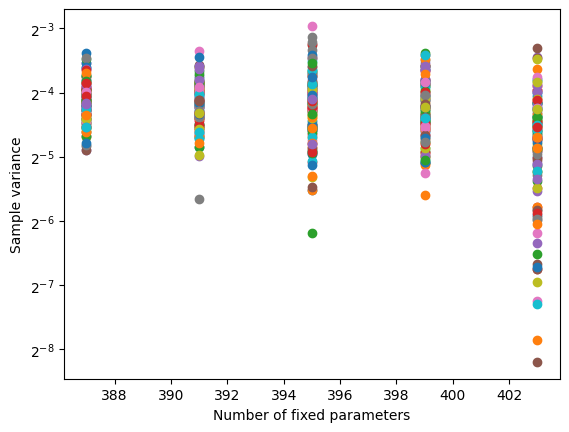

In [8]:
exp.plot_results()
plt.yscale('log')

In [6]:
shexperiment = ShallowingExperiment.load('shtest')

In [11]:
num_qubits = 6
num_layers = 100
shexperiment.run(num_qubits, num_layers, 5, 50)

f [0, 606, 909, 1060, 1136, 1174, 1193, 1202, 1207, 1209]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

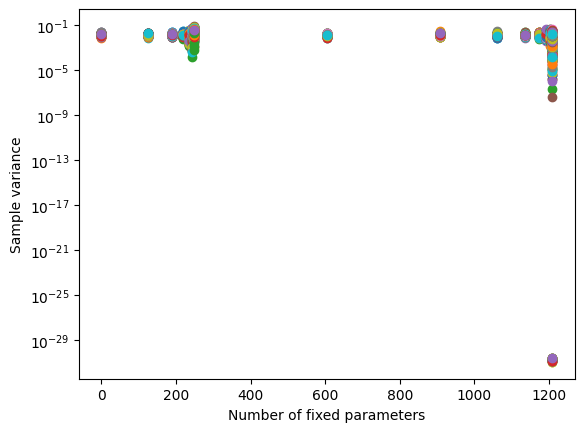

In [12]:
shexperiment.plot_results()
plt.yscale('log')

In [ ]:
uniform_bp_exp = UniformBPExperiement.load('uniform_test')


In [150]:
uniform_bp_exp = UniformBPExperiement.load('uniform_test')
uniform_bp_exp.run([8], range(10, 50+1, 10), 10)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Uniform BP

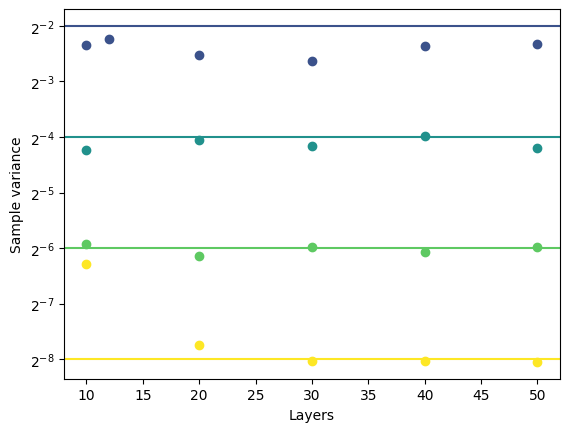

In [151]:
uniform_bp_exp.plot_results()

In [136]:
uniform_bp_exp.results[2][10].mean()

Array(-0.0584208, dtype=float32)

In [50]:
uniform_bp_exp.save()

In [51]:
UniformBPExperiement.load(uniform_bp_exp.name)

UniformBPExperiement(name='uniform_test', results=None)